Here we look to see if there is any natural clustering in the data.

To do so, we do the following:
- k-means
- PCA
- Fisher's LDA

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pywt
import csv
import glob
import os
import glob
import tqdm
import datetime
import scipy

# load data
X = np.load("data/data_X.npy")
bad_y = np.load("data/data_y.npy")
X_dft = np.load("data/X_dft.npy")
X_dwt = np.load("data/X_dwt.npy")

In [2]:
y = bad_y
for i in range(y.shape[0]):
    if bad_y[i] > 5:
        y[i] = bad_y[i] - 1
        
np.unique(y)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21.])

In [3]:
X.shape

(6372, 96)

### pca

In [4]:
# first fit PCA
pca = PCA(n_components=20)
pca.fit(X.T)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

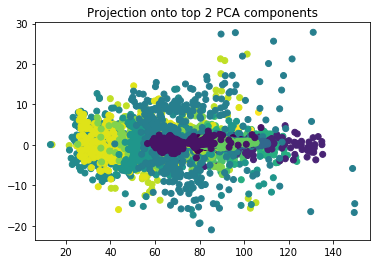

In [5]:
# then plot some information
projected = pca.components_ @ X.T
plt.scatter(projected[0,:], projected[1,:], c=y)
plt.title("Projection onto top 2 PCA components")
plt.show()

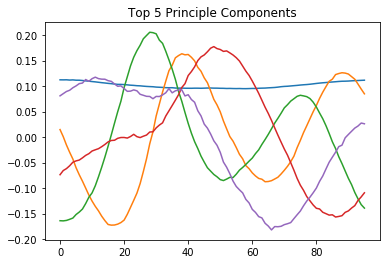

In [6]:
# look at top 5 principle components of our PCA decomposition
num_top_components = 5
for i in range(num_top_components):
    plt.plot(pca.components_[i, :])
    
plt.title("Top 5 Principle Components")
plt.show()

In [30]:
pca.components_.shape

(20, 96)

### Do PCA for transformed data as well

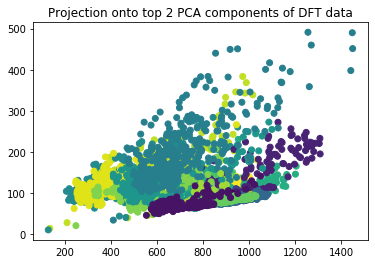

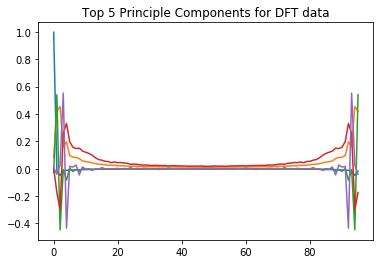

In [8]:
# fit PCA model
pca_dft = PCA(n_components=20)
pca_dft.fit(X_dft)
# then plot some information
projected_dft = pca_dft.components_ @ X_dft.T
plt.scatter(projected_dft[0,:], projected_dft[1,:], c=y)
plt.title("Projection onto top 2 PCA components of DFT data")
plt.show()
# look at top 5 principle components of our PCA decomposition
num_top_components = 5
for i in range(num_top_components):
    plt.plot(pca_dft.components_[i, :])
    
plt.title("Top 5 Principle Components for DFT data")
plt.show()

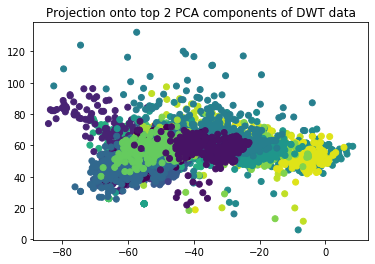

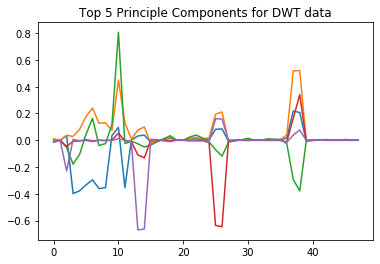

In [11]:
# fit PCA model
pca_dwt = PCA(n_components=20)
pca_dwt.fit(X_dwt)
# then plot some information
projected_dwt = pca_dwt.components_ @ X_dwt.T
plt.scatter(projected_dwt[0,:], projected_dwt[1,:], c=y)
plt.title("Projection onto top 2 PCA components of DWT data")
plt.show()
# look at top 5 principle components of our PCA decomposition
num_top_components = 5
for i in range(num_top_components):
    plt.plot(pca_dwt.components_[i, :])
    
plt.title("Top 5 Principle Components for DWT data")
plt.show()

### k-means

In [12]:
from sklearn.cluster import KMeans

num_clusters = 22 #np.unique(y).shape[0]

raw_kmeans = KMeans(n_clusters=num_clusters)
raw_kmeans.fit(X)

print(raw_kmeans.labels_)

[14 14 14 ... 17 17 17]


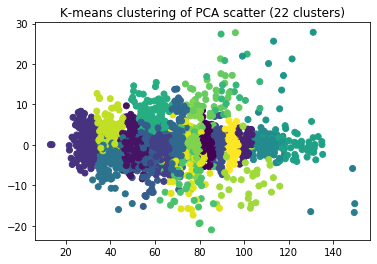

In [13]:
plt.scatter(projected[0,:], projected[1,:], c=raw_kmeans.labels_)
plt.title("K-means clustering of PCA scatter (22 clusters)")
plt.show()

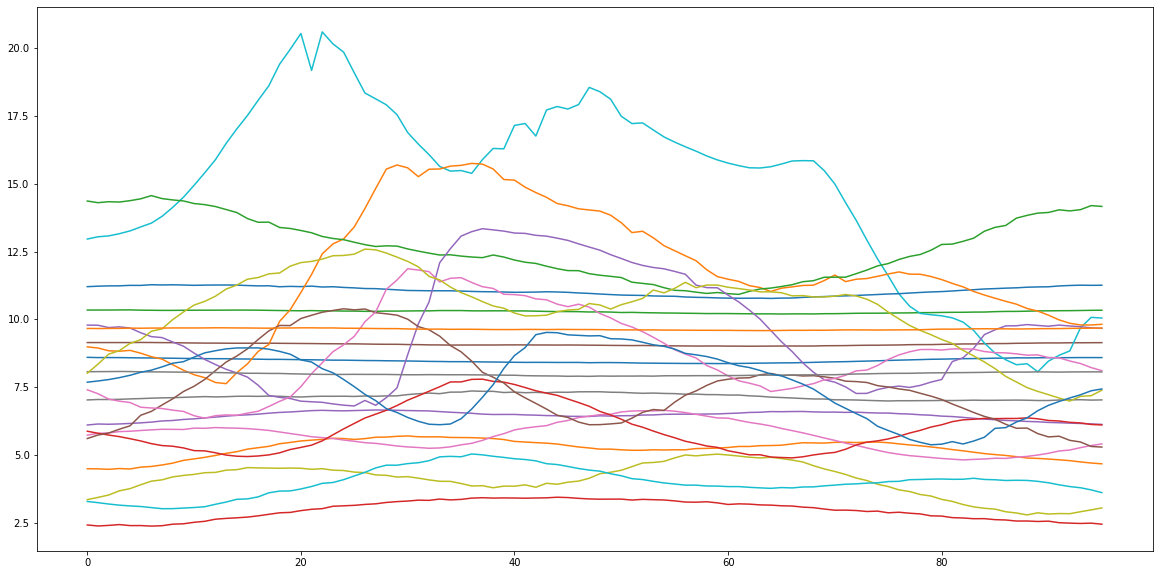

In [14]:
# look at k-means centroids
plt.figure(figsize=(20,10))
for i in range(22):
    plt.plot(raw_kmeans.cluster_centers_[i,:])

### Agglomerative Clustering

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21]), array([ 397, 1226,  856,  193,   47,   77,  294,   40,  137,   13,  121,
        192,  481,    5,   48,   41,   56,  228, 1090,  673,   42,  115]))
(6372,)


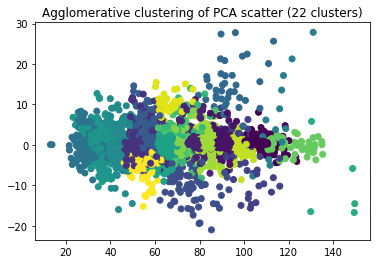

In [15]:
from sklearn.cluster import AgglomerativeClustering

num_clusters = 4 #np.unique(y).shape[0]

raw_agglo = AgglomerativeClustering(n_clusters=22)
raw_agglo.fit(X)

print(np.unique(raw_agglo.labels_, return_counts=True))
print(raw_agglo.labels_.shape)

plt.scatter(projected[0,:], projected[1,:], c=raw_agglo.labels_)
plt.title("Agglomerative clustering of PCA scatter (22 clusters)")
plt.show()

### Fisher's LDA

In [35]:
# start by getting means
num_groups = np.unique(y).shape[0]
dim = X.shape[1]
mu = np.mean(X, axis = 0)
mu_group = np.zeros((num_groups, dim))
for i in range(num_groups):
    group = i
    group_X = X[y == group, :]
    mu_group[i, :] = np.mean(group_X, axis = 0)

In [36]:
# scatter matrices
def calc_cov_mat(data, class_mean):
    num_samples = data.shape[0]
    sample_length = data.shape[1]
    
    S = np.zeros((sample_length, sample_length))
    
    for j in range(num_samples):
        demeaned = data[j, :] - class_mean
        S += np.outer(demeaned, demeaned)
        
    return S

scatter_mats = {}

for i in range(num_groups):
    group = i
    group_X = X[y == group, :]
    scatter_mats[i] = calc_cov_mat(group_X, mu_group[i,:])
    
S_W = np.zeros((dim, dim))
for i in range(num_groups):
    S_W += scatter_mats[i]

In [37]:
# between scatter matrices
_, N_k = np.unique(y, return_counts=True)
S_B = np.zeros((dim, dim))
for i in range(num_groups):
    S_B += N_k[i] * np.outer(mu_group[i, :] - mu, mu_group[i, :] - mu)

In [38]:
# project onto space of highest eigenvalues
eig_vals, eig_vecs = scipy.linalg.eig(S_W, S_B)
highest_eigs_idx = np.argsort(eig_vals)[0:2]
W_highest = eig_vecs[:,highest_eigs_idx]

projected_data = W_highest.T @ X.T
print(projected_data.shape)

(2, 6372)


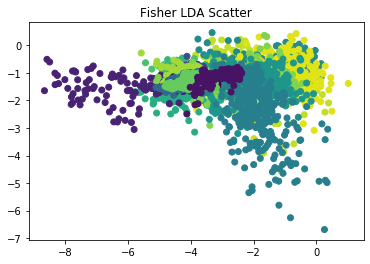

In [39]:
plt.scatter(projected_data[0,:], projected_data[1,:], c=y)
plt.title("Fisher LDA Scatter")
plt.show()

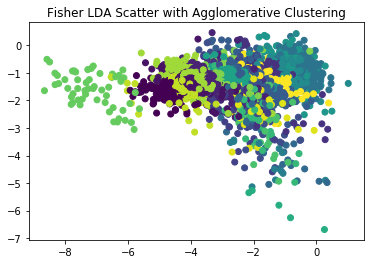

In [42]:
plt.scatter(projected_data[0,:], projected_data[1,:], c=raw_agglo.labels_)
plt.title("Fisher LDA Scatter with Agglomerative Clustering")
plt.show()

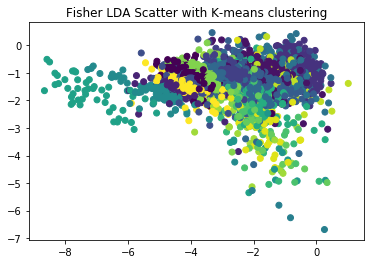

In [43]:
plt.scatter(projected_data[0,:], projected_data[1,:], c=raw_kmeans.labels_)
plt.title("Fisher LDA Scatter with K-means clustering")
plt.show()

### Now do Fisher's LDA with DFT and DWT data

(2, 6372)


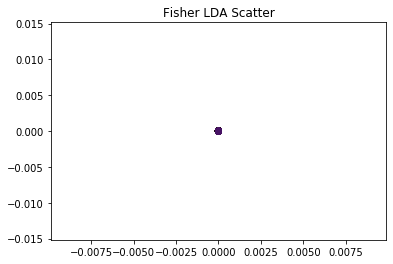

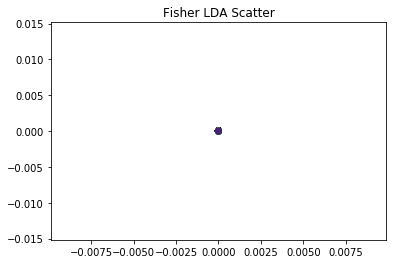

In [24]:
# dft 
# start by getting means
num_groups = np.unique(y).shape[0]
dim = X_dft.shape[1]
mu = np.mean(X_dft, axis = 0)
mu_group = np.zeros((num_groups, dim))
for i in range(num_groups):
    group = i
    group_X = X_dft[y == group, :]
    mu_group[i, :] = np.mean(group_X, axis = 0)
    
# scatter matrices
def calc_cov_mat(data, class_mean):
    num_samples = data.shape[0]
    sample_length = data.shape[1]
    
    S = np.zeros((sample_length, sample_length))
    
    for j in range(num_samples):
        demeaned = data[j, :] - class_mean
        S += np.outer(demeaned, demeaned)
        
    return S

scatter_mats = {}

for i in range(num_groups):
    group = i
    group_X = X_dft[y == group, :]
    scatter_mats[i] = calc_cov_mat(group_X, mu_group[i,:])
    
S_W = np.zeros((dim, dim))
for i in range(num_groups):
    S_W += scatter_mats[i]
    
# between scatter matrices
_, N_k = np.unique(y, return_counts=True)
S_B = np.zeros((dim, dim))
for i in range(num_groups):
    S_B += N_k[i] * np.outer(mu_group[i, :] - mu, mu_group[i, :] - mu)
    
# project onto space of highest eigenvalues
eig_vals, eig_vecs = scipy.linalg.eig(S_W, S_B)
highest_eigs_idx = np.argsort(eig_vals)[0:2]
W_highest = eig_vecs[:,highest_eigs_idx]

projected_data = W_highest.T @ X_dft.T
print(projected_data.shape)

plt.scatter(projected_data[0,:], projected_data[1,:], c=y)
plt.title("Fisher LDA Scatter")
plt.show()

plt.scatter(projected_data[0,:], projected_data[1,:], c=raw_agglo.labels_)
plt.title("Fisher LDA Scatter")
plt.show()

(2, 6372)


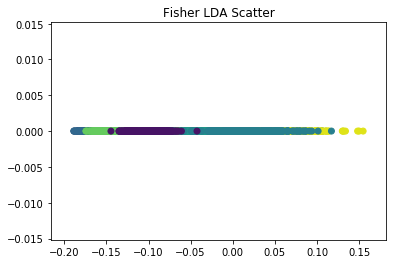

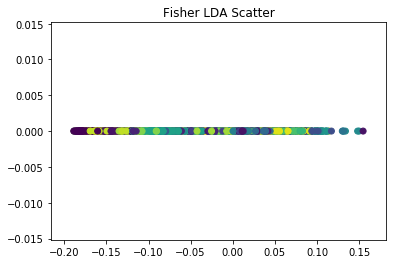

In [25]:
# dwt 
# start by getting means
num_groups = np.unique(y).shape[0]
dim = X_dwt.shape[1]
mu = np.mean(X_dwt, axis = 0)
mu_group = np.zeros((num_groups, dim))
for i in range(num_groups):
    group = i
    group_X = X_dwt[y == group, :]
    mu_group[i, :] = np.mean(group_X, axis = 0)
    
# scatter matrices
def calc_cov_mat(data, class_mean):
    num_samples = data.shape[0]
    sample_length = data.shape[1]
    
    S = np.zeros((sample_length, sample_length))
    
    for j in range(num_samples):
        demeaned = data[j, :] - class_mean
        S += np.outer(demeaned, demeaned)
        
    return S

scatter_mats = {}

for i in range(num_groups):
    group = i
    group_X = X_dwt[y == group, :]
    scatter_mats[i] = calc_cov_mat(group_X, mu_group[i,:])
    
S_W = np.zeros((dim, dim))
for i in range(num_groups):
    S_W += scatter_mats[i]
    
# between scatter matrices
_, N_k = np.unique(y, return_counts=True)
S_B = np.zeros((dim, dim))
for i in range(num_groups):
    S_B += N_k[i] * np.outer(mu_group[i, :] - mu, mu_group[i, :] - mu)
    
# project onto space of highest eigenvalues
eig_vals, eig_vecs = scipy.linalg.eig(S_W, S_B)
highest_eigs_idx = np.argsort(eig_vals)[0:2]
W_highest = eig_vecs[:,highest_eigs_idx]

projected_data = W_highest.T @ X_dwt.T
print(projected_data.shape)

plt.scatter(projected_data[0,:], projected_data[1,:], c=y)
plt.title("Fisher LDA Scatter")
plt.show()

plt.scatter(projected_data[0,:], projected_data[1,:], c=raw_agglo.labels_)
plt.title("Fisher LDA Scatter")
plt.show()

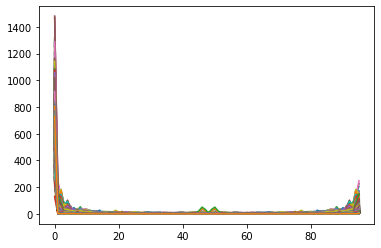

In [28]:
for i in range(X_dft.shape[0]):
    plt.plot(X_dft[i,:])
    
plt.show()

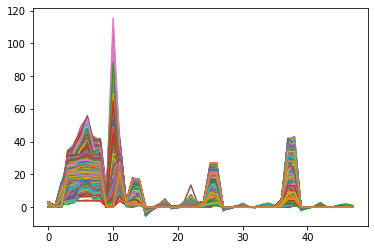

In [29]:
for i in range(X_dwt.shape[0]):
    plt.plot(X_dwt[i,:])
    
plt.show()